In [1]:
import os

import pandas as pd
from pandas.api.types import is_string_dtype as ist
from pandas.api import types

import numpy as np
import torch
import networkx as nx

import itertools
import time
import warnings
import random
import re

from scipy import stats
from scipy.spatial import distance
from scipy.spatial.distance import pdist
from scipy import stats
from scipy.stats.contingency import expected_freq
from scipy.spatial import distance
from scipy.signal import convolve2d
from scipy.sparse import csgraph
from scipy.sparse.linalg import eigsh

from sklearn import cluster
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModel

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
filenames = {}

def extract(filename):
    return pd.read_csv(filename, sep=',')

def read_files(directory, max_kb):
    dfs = {}
    i = 0
    for filename in os.listdir(directory):
        i = i+1
        size = os.stat(f'{directory}\\{filename}').st_size
        if max_kb == 0 or size <= max_kb:
            f = os.path.join(directory, filename)
            if os.path.isfile(f):
                new_f = str(i).zfill(5)
                filenames[new_f] = filename
                dfs[new_f]= extract(f)
    return dfs

In [3]:
dfs = read_files('data\\domain_net', 0)
len(dfs)

1327

In [4]:
list(dfs.values())[0]

Branch name Continent name Country/region name  \
0                        OGM Asia Pacific           Asia          Bangladesh   
1                        OGM Asia Pacific           Asia          Bangladesh   
2                        OGM Asia Pacific           Asia          Bangladesh   
3     EGM Europe, Middle East and Maghreb           Asia      West Bank Gaza   
4                  WGM Sub-Saharan Africa         Africa                Mali   
...                                   ...            ...                 ...   
4645                         NGM Americas        America              Guyana   
4646                         NGM Americas        America             Jamaica   
4647                         NGM Americas        America      St.Kitts Nevis   
4648                         NGM Americas        America         Saint Lucia   
4649                         NGM Americas        America          Montserrat   

                           Division name Organisation class  \
0                   OAD Asia Programming         Individual   
1                   OAD Asia Programming         Individual   
2                   OAD Asia Programming         Individual   
3     EDD Europe-Middle East Programming       Governmental   
4              WWD West & Central Africa       Governmental   
...                                  ...                ...   
4645            NDD Americas Programming      Civil Society   
4646            NDD Americas Programming      Civil Society   
4647            NDD Americas Programming      Civil Society   
4648            NDD Americas Programming      Civil Society   
4649            NDD Americas Programming      Civil Society   

     Organisation type (location, profit/not-for-profit) PBA type  
0                                Canadian Profit Making   Not PBA  
1                                Canadian Profit Making   Not PBA  
2                                Canadian Profit Making   Not PBA  
3                            Canadian Non-Profit Making   Not PBA  
4                            Canadian Non-Profit Making   Not PBA  
...                                                 ...       ...  
4645                             Canadian Profit Making   Not PBA  
4646                             Canadian Profit Making   Not PBA  
4647                             Canadian Profit Making   Not PBA  
4648                             Canadian Profit Making   Not PBA  
4649                             Canadian Profit Making   Not PBA  

[4650 rows x 7 columns]

In [5]:
dfs_new = {}
for key, df in dfs.items():
    s = len(df.columns)
    #print(s)
    if s >= 5:
        dfs_new[key]=df
len(dfs_new)

869

In [6]:
list(dfs_new.values())[400]

Address  \
0     ALLTYCNAP ROAD, COACH DEPOT, JOHNSTOWN, CARMAR...   
1     ALLTYCNAP ROAD, COACH DEPOT, JOHNSTOWN, CARMAR...   
2     ALLTYCNAP ROAD, COACH DEPOT, JOHNSTOWN, CARMAR...   
3     ALLTYCNAP ROAD, COACH DEPOT, JOHNSTOWN, CARMAR...   
4     ALLTYCNAP ROAD, COACH DEPOT, JOHNSTOWN, CARMAR...   
...                                                 ...   
4659  VIADUCT ROAD, L HERITAGE, GARNDIFFAITH, PONTYP...   
4660  VIADUCT ROAD, L HERITAGE, GARNDIFFAITH, PONTYP...   
4661  VIADUCT ROAD, L HERITAGE, GARNDIFFAITH, PONTYP...   
4662  PONTYATES, 2 CAE CANVAS COTTAGES, LLANELLI, SA...   
4663  PONTYATES, 2 CAE CANVAS COTTAGES, LLANELLI, SA...   

                          Auth_Description     Lic_No  \
0                  Carmarthenshire Council  PG0007563   
1                Ceredigion County Council  PG0007563   
2                  Carmarthenshire Council  PG0007563   
3                Ceredigion County Council  PG0007563   
4                  Carmarthenshire Council  PG0007563   
...                                    ...        ...   
4659  Gwent Joint Passenger Transport Unit  PG1143829   
4660  Gwent Joint Passenger Transport Unit  PG1143829   
4661                       Torfaen Council  PG1143829   
4662               Carmarthenshire Council  PG1144486   
4663               Carmarthenshire Council  PG1144486   

                                               Pub_Text        Reg_No  \
0     Operating between Llandysul and Carmarthen Sch...   PG0007563/9   
1     Operating between Llandysul and Carmarthen Sch...   PG0007563/9   
2     Operating between Llandysul and Carmarthen Sch...   PG0007563/9   
3     Operating between Llandysul and Carmarthen Sch...   PG0007563/9   
4     From: Carmarthen Barn Road\nTo: Johnstown, C P...  PG0007563/10   
...                                                 ...           ...   
4659  Operating between Brynmawr Bus Station and Par...  PG1143829/10   
4660  From: Cwmbran Bus Station\nTo: Cwmbran Bus Sta...  PG1143829/11   
4661  From: Cwmbran Bus Station\nTo: Cwmbran Bus Sta...  PG1143829/11   
4662  From: Sandy Rd, Pwll A484\nTo: St John Lloyds ...   PG1144486/1   
4663  From: Swiss Valley / Sandy Road\nTo: Ysgol Y S...   PG1144486/2   

     Registration Status Service_Type_Description    Subsidies_Details  \
0             Registered        Rural Bus Service  Carmarthenshire C C   
1             Registered        Rural Bus Service  Carmarthenshire C C   
2              Cancelled        Rural Bus Service  Carmarthenshire C C   
3              Cancelled        Rural Bus Service  Carmarthenshire C C   
4             Registered          School or Works  Carmarthenshire C C   
...                  ...                      ...                  ...   
4659          Registered              Hail & Ride                  NaN   
4660          Registered              Hail & Ride                  NaN   
4661          Registered              Hail & Ride                  NaN   
4662          Registered          School or Works   Carmarthenshire cc   
4663          Registered          School or Works                  NaN   

                        trading_name                           via  
0                                NaN                      Pencader  
1                                NaN                      Pencader  
2                                NaN                      Pencader  
3                                NaN                      Pencader  
4                                NaN                  Model School  
...                              ...                           ...  
4659   PHIL  ANSLOW AND SONS COACHES                   Abertillery  
4660   PHIL  ANSLOW AND SONS COACHES                    Llanyravon  
4661   PHIL  ANSLOW AND SONS COACHES                    Llanyravon  
4662  D R TAXIS MINIBUS & COACH HIRE            Sandy Rd, West End  
4663  D R TAXIS MINIBUS & COACH HIRE  Panteg, Westend, Park Howard  

[4664 rows x 10 columns]

In [7]:
def remove_s(adf):
    for col in adf:
        m = adf.loc[adf[col] != 's']
        m = m[col].mode()[0]
        adf[col].replace('s', m, inplace=True)
        
def conver_percent(adf):
    return adf.apply(lambda x: x.str.rstrip("%").astype(float)/100 if ist(x) and x.str.match(pat='%$').any() else x)

def fill_na(adf):
    for col in adf:
        if types.is_numeric_dtype(adf[col].dtypes):
            skew = stats.skew(adf[col])
            normal = True if -0.5 > skew or skew < 0.5 else False
            if normal:
                mean = adf[col].mean()
                adf[col].fillna(int(mean), inplace=True)            
            else:
                median = adf[col].median()
                adf[col].fillna(median, inplace=True)
        else:
            mode = adf[col].mode()
            adf[col].fillna(mode, inplace=True)

In [8]:
for key, df in dfs_new.items():
    df.replace('-', np.nan, inplace=True) #replace all '-' values with NaN
    df.dropna(how="all", axis=1, inplace=True) #drop columns where all values are NaN
    remove_s(df) #replace column values of 's' with mode()
    df = conver_percent(df) #convert string percent
    fill_na(df)
    dfs_new[key] = df

In [9]:
dfs_new[list(dfs_new)[3]]

Branch name Continent name  \
0     KFM Partnership for Develop. Innovation        America   
1     KFM Partnership for Develop. Innovation        America   
2     KFM Partnership for Develop. Innovation        America   
3     KFM Partnership for Develop. Innovation        America   
4     KFM Partnership for Develop. Innovation        America   
...                                       ...            ...   
4645  KFM Partnership for Develop. Innovation        America   
4646  KFM Partnership for Develop. Innovation        America   
4647  KFM Partnership for Develop. Innovation        America   
4648  KFM Partnership for Develop. Innovation        America   
4649  KFM Partnership for Develop. Innovation        America   

     Country/region name                             Division name  \
0             Costa Rica  KGD Sustainable Economic Growth Partner.   
1             Costa Rica  KGD Sustainable Economic Growth Partner.   
2             Costa Rica  KGD Sustainable Economic Growth Partner.   
3             Costa Rica  KGD Sustainable Economic Growth Partner.   
4             Costa Rica  KGD Sustainable Economic Growth Partner.   
...                  ...                                       ...   
4645               Haiti       KSD Social Development Partnerships   
4646               Haiti       KSD Social Development Partnerships   
4647               Haiti       KSD Social Development Partnerships   
4648               Haiti       KSD Social Development Partnerships   
4649               Haiti       KSD Social Development Partnerships   

     Organisation class Organisation type (location, profit/not-for-profit)  \
0         Civil Society                         Canadian Non-Profit Making    
1         Civil Society                         Canadian Non-Profit Making    
2         Civil Society                         Canadian Non-Profit Making    
3         Civil Society                         Canadian Non-Profit Making    
4         Civil Society                         Canadian Non-Profit Making    
...                 ...                                                ...    
4645      Civil Society                         Canadian Non-Profit Making    
4646      Civil Society                         Canadian Non-Profit Making    
4647      Civil Society                         Canadian Non-Profit Making    
4648      Civil Society                         Canadian Non-Profit Making    
4649      Civil Society                         Canadian Non-Profit Making    

     PBA type  
0     Not PBA  
1     Not PBA  
2     Not PBA  
3     Not PBA  
4     Not PBA  
...       ...  
4645  Not PBA  
4646  Not PBA  
4647  Not PBA  
4648  Not PBA  
4649  Not PBA  

[4650 rows x 7 columns]

In [10]:
dfs_new2 = dict(itertools.islice(dfs_new.items(), 50))
#dfs_new2 = dfs_new.copy()
len(list(dfs_new2))

50

In [11]:
qual_data = {}
quan_data = {}
def separate(dfs, qual_data, quan_data):
    for t_name, df in dfs.items():    
        for (idx, col) in enumerate(df):
            #print(f'idx[{idx}],col[{col}]')
            if not types.is_numeric_dtype(df[col].dtypes):
                if not t_name in qual_data:
                    qual_data[t_name] = []
                qual_data[t_name].append(col)
            else:
                if not t_name in quan_data:
                    quan_data[t_name] = []
                quan_data[t_name].append(col)

separate(dfs_new2, qual_data, quan_data)

In [12]:
class Node:
    def __init__(self, t_name):
        self.t_name = t_name
        self.similarities = {}
    
    def score_add(self, to_name, score):
        if self.similarities.get(to_name):
            prev_score = self.similarities.get(to_name)
            score = (prev_score + score)/2
        self.similarities[to_name] = score

def compare(data, dfs, res, quan=0):
    def compareit(res, t_name1, col1, t_name2, col2):
        df1 = dfs[t_name1]
        x = sorted(df1[col1])
        df2 = dfs[t_name2]        
        y = sorted(df2[col2])
        s = len(x) if len(x) < len(y) else len(y)
        
        src_node = res.get(t_name1)
        dst_node = res.get(t_name2)
        if not src_node:
            src_node = Node(t_name1)
            res[t_name1] = src_node
        if not dst_node:
            dst_node = Node(t_name2)
            res[t_name2] = dst_node
        
        if quan==0:
            contingency = pd.crosstab(x[:s], y[:s])
            cs = np.sum(contingency)
            valid = all(v > 0 for v in cs)
            if (valid):
                c, p, dof, expected = stats.chi2_contingency(contingency)
                if p is not np.nan and p is not np.inf:
                    src_node.score_add(t_name2, p)
                    dst_node.score_add(t_name1, p)
        else:
            p = distance.jensenshannon(x[:s], y[:s], axis=0)
            if p is not np.nan and p is not np.inf and p < 0.1:
                src_node.score_add(t_name2, p)
                dst_node.score_add(t_name1, p)

    for i, t_name1 in enumerate(data):
        for j, t_name2 in enumerate(data):
            if i==j:
                continue
            elif i<j:                
                [compareit(res, t_name1, col1, t_name2, col2) for i, col1 in enumerate(data[t_name1]) for j, col2 in enumerate(data[t_name2])]

In [13]:
start_time = time.time()

res = {}
compare(qual_data, dfs_new2, res)
compare(quan_data, dfs_new2, res, quan=1)

elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 00:40:25


In [14]:
def plot_cat(data, x, cols, size):
    fig = plt.figure(figsize = size)
    fig.subplots_adjust(top=1.5, hspace=0.3, wspace=0.3)
    for i in range(len(cols)):
        ax = fig.add_subplot(4,2,(i+1))
        plt.xticks(rotation=45)
        sns.countplot(x=data.columns[x], hue=data.columns[cols[i]], data=data, ax=ax)
    fig.show()

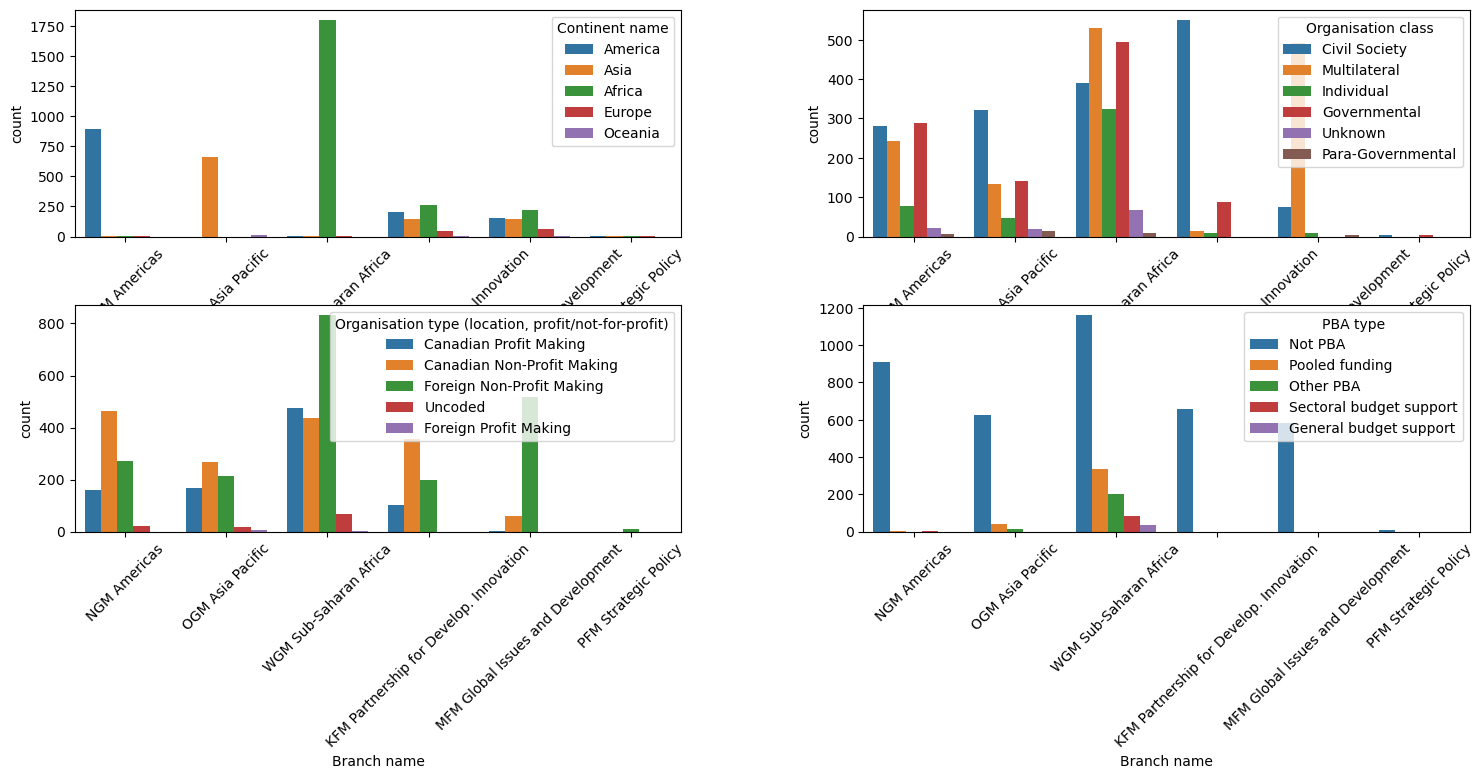

In [15]:
data = list(dfs_new2.values())[1]
cols = [1,5,6,7]
plot_cat(data, 0, cols, (18,8))

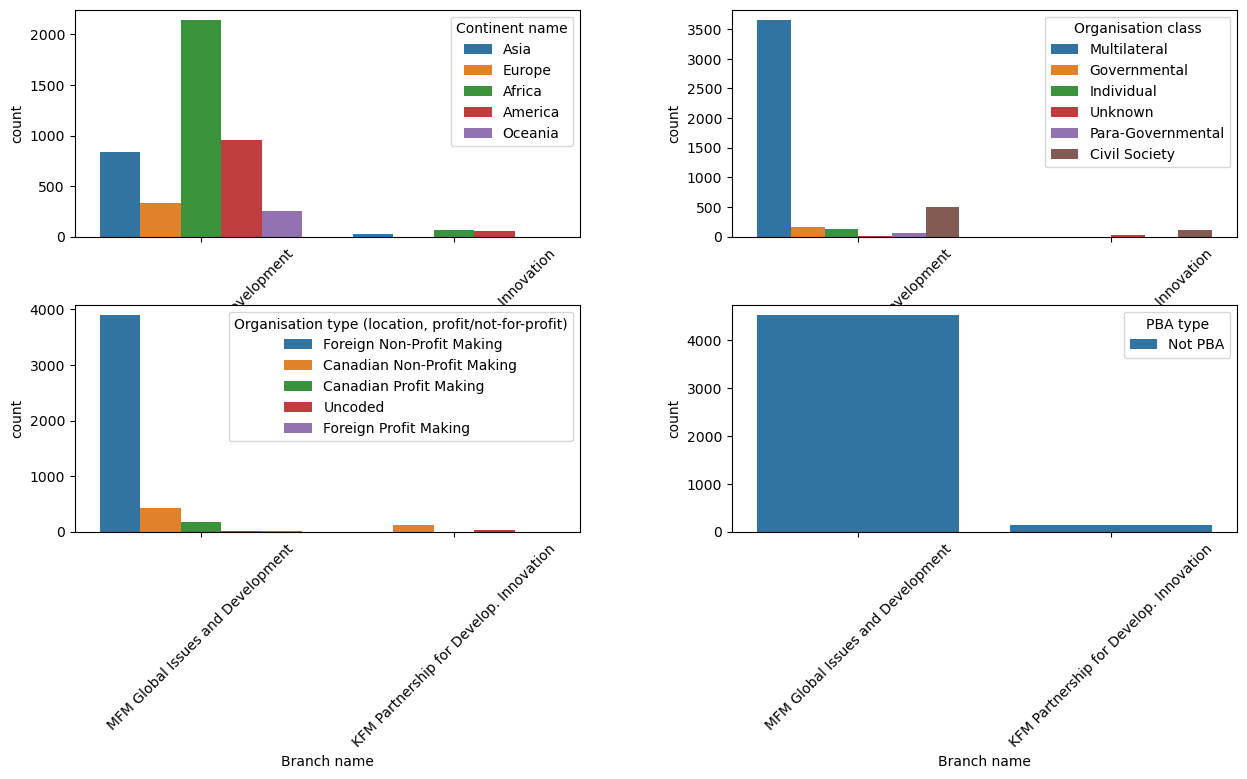

In [16]:
data = list(dfs_new2.values())[2]
cols = [1,5,6,7]
plot_cat(data, 0, cols, (15,8))

In [17]:
data = list(dfs_new2.values())[1]
data

Branch name Continent name Country/region name  \
0                          NGM Americas        America            Suriname   
1                          NGM Americas        America     Trinidad/Tobago   
2                          NGM Americas        America     St.Vincent & Gr   
3                      OGM Asia Pacific           Asia         Philippines   
4                      OGM Asia Pacific           Asia         Philippines   
...                                 ...            ...                 ...   
4645  MFM Global Issues and Development           Asia                Asia   
4646  MFM Global Issues and Development           Asia                Asia   
4647  MFM Global Issues and Development           Asia                Asia   
4648  MFM Global Issues and Development           Asia                Asia   
4649  MFM Global Issues and Development           Asia                Asia   

                          Division name Organisation ID Organisation class  \
0              NDD Americas Programming         1012531      Civil Society   
1              NDD Americas Programming         1012531      Civil Society   
2              NDD Americas Programming         1012531      Civil Society   
3                  OAD Asia Programming         1001102      Civil Society   
4                  OAD Asia Programming         1001102      Civil Society   
...                                 ...             ...                ...   
4645  MSD Food Security and Environment         1007310       Multilateral   
4646  MSD Food Security and Environment         1007310       Multilateral   
4647  MSD Food Security and Environment         1007310       Multilateral   
4648  MSD Food Security and Environment         1007310       Multilateral   
4649  MSD Food Security and Environment         1007310       Multilateral   

     Organisation type (location, profit/not-for-profit) PBA type  
0                                Canadian Profit Making   Not PBA  
1                                Canadian Profit Making   Not PBA  
2                                Canadian Profit Making   Not PBA  
3                            Canadian Non-Profit Making   Not PBA  
4                            Canadian Non-Profit Making   Not PBA  
...                                                 ...       ...  
4645                          Foreign Non-Profit Making   Not PBA  
4646                          Foreign Non-Profit Making   Not PBA  
4647                          Foreign Non-Profit Making   Not PBA  
4648                          Foreign Non-Profit Making   Not PBA  
4649                          Foreign Non-Profit Making   Not PBA  

[4650 rows x 8 columns]

In [18]:
data = list(dfs_new2.values())[17]
data

Branch name Country/region name  \
0           MFM Global Issues and Development                Asia   
1           MFM Global Issues and Development                Asia   
2           MFM Global Issues and Development                Asia   
3           MFM Global Issues and Development                Asia   
4           MFM Global Issues and Development                Asia   
...                                       ...                 ...   
4645  KFM Partnership for Develop. Innovation               China   
4646  KFM Partnership for Develop. Innovation               China   
4647  KFM Partnership for Develop. Innovation               China   
4648  KFM Partnership for Develop. Innovation               China   
4649  KFM Partnership for Develop. Innovation          Costa Rica   

                 Fund centre name                      Organisation name  \
0              Environment - INIT  UNU-INWEH - United Nations University   
1              Environment - INIT  UNU-INWEH - United Nations University   
2              Environment - INIT  UNU-INWEH - United Nations University   
3              Environment - INIT  UNU-INWEH - United Nations University   
4              Environment - INIT  UNU-INWEH - United Nations University   
...                           ...                                    ...   
4645  Sustainable Economic Growth         Colleges and Institutes Canada   
4646  Sustainable Economic Growth         Colleges and Institutes Canada   
4647  Sustainable Economic Growth         Colleges and Institutes Canada   
4648  Sustainable Economic Growth         Colleges and Institutes Canada   
4649  Sustainable Economic Growth         Colleges and Institutes Canada   

     Organisation sub-class  \
0            UNITED NATIONS   
1            UNITED NATIONS   
2            UNITED NATIONS   
3            UNITED NATIONS   
4            UNITED NATIONS   
...                     ...   
4645  UMBRELLA ORGANIZATION   
4646  UMBRELLA ORGANIZATION   
4647  UMBRELLA ORGANIZATION   
4648  UMBRELLA ORGANIZATION   
4649  UMBRELLA ORGANIZATION   

     Organisation type (location, profit/not-for-profit)  \
0                             Foreign Non-Profit Making    
1                             Foreign Non-Profit Making    
2                             Foreign Non-Profit Making    
3                             Foreign Non-Profit Making    
4                             Foreign Non-Profit Making    
...                                                 ...    
4645                         Canadian Non-Profit Making    
4646                         Canadian Non-Profit Making    
4647                         Canadian Non-Profit Making    
4648                         Canadian Non-Profit Making    
4649                         Canadian Non-Profit Making    

                                            Sector name  
0     Water sector policy and administrative management  
1     Water sector policy and administrative management  
2     Water sector policy and administrative management  
3     Water sector policy and administrative management  
4     Water sector policy and administrative management  
...                                                 ...  
4645                                   Health education  
4646                       Health personnel development  
4647                    Agricultural education/training  
4648                   Environmental education/training  
4649                                   Teacher training  

[4650 rows x 7 columns]

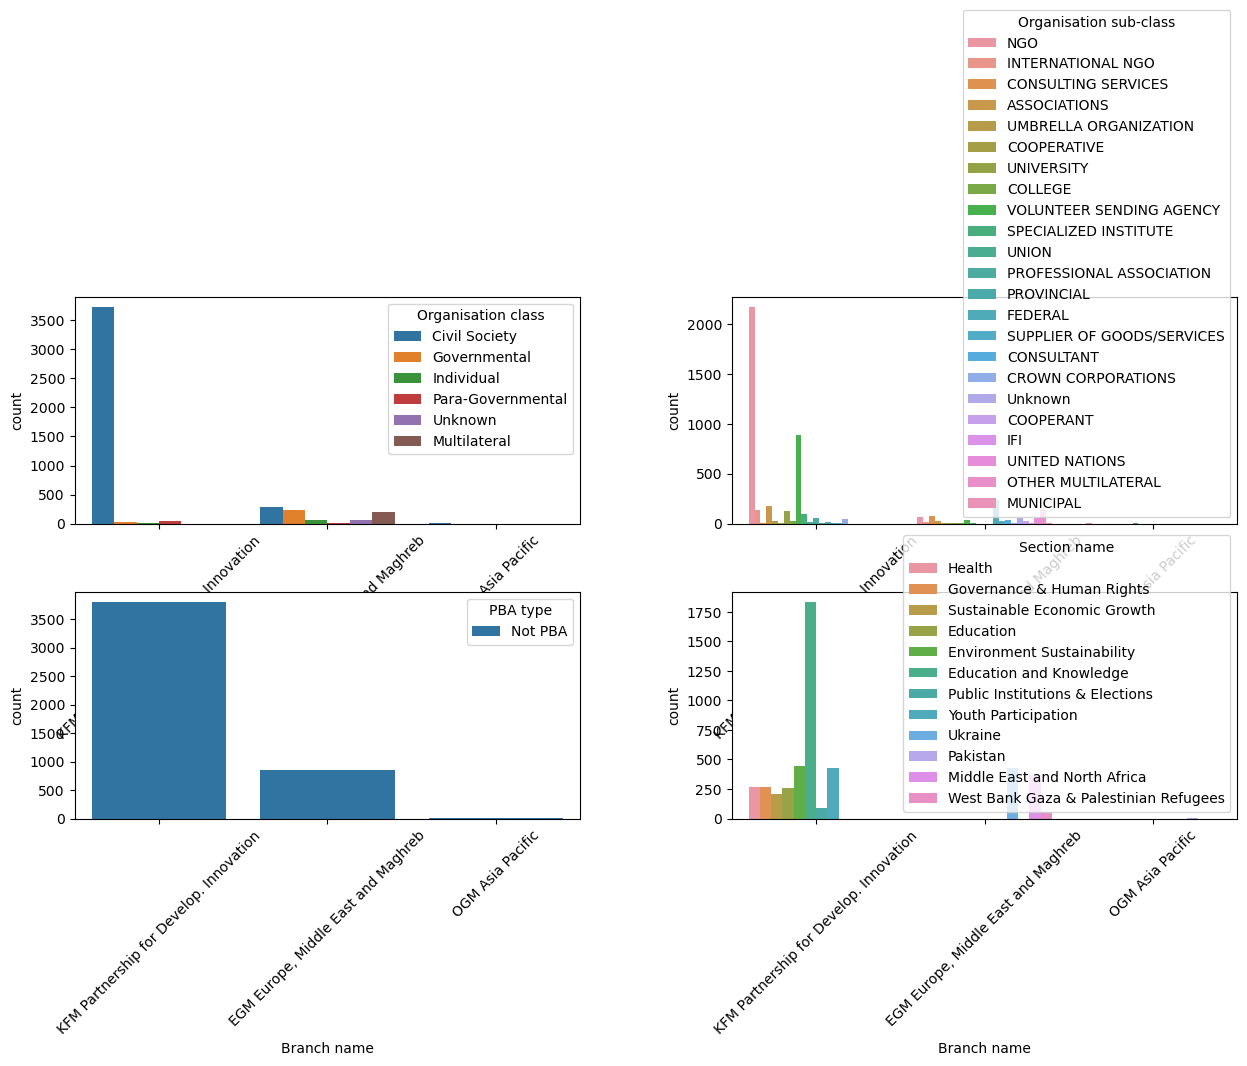

In [19]:
data = list(dfs_new2.values())[44]
cols = [2,4,5,7]
plot_cat(data, 0, cols, (15,8))

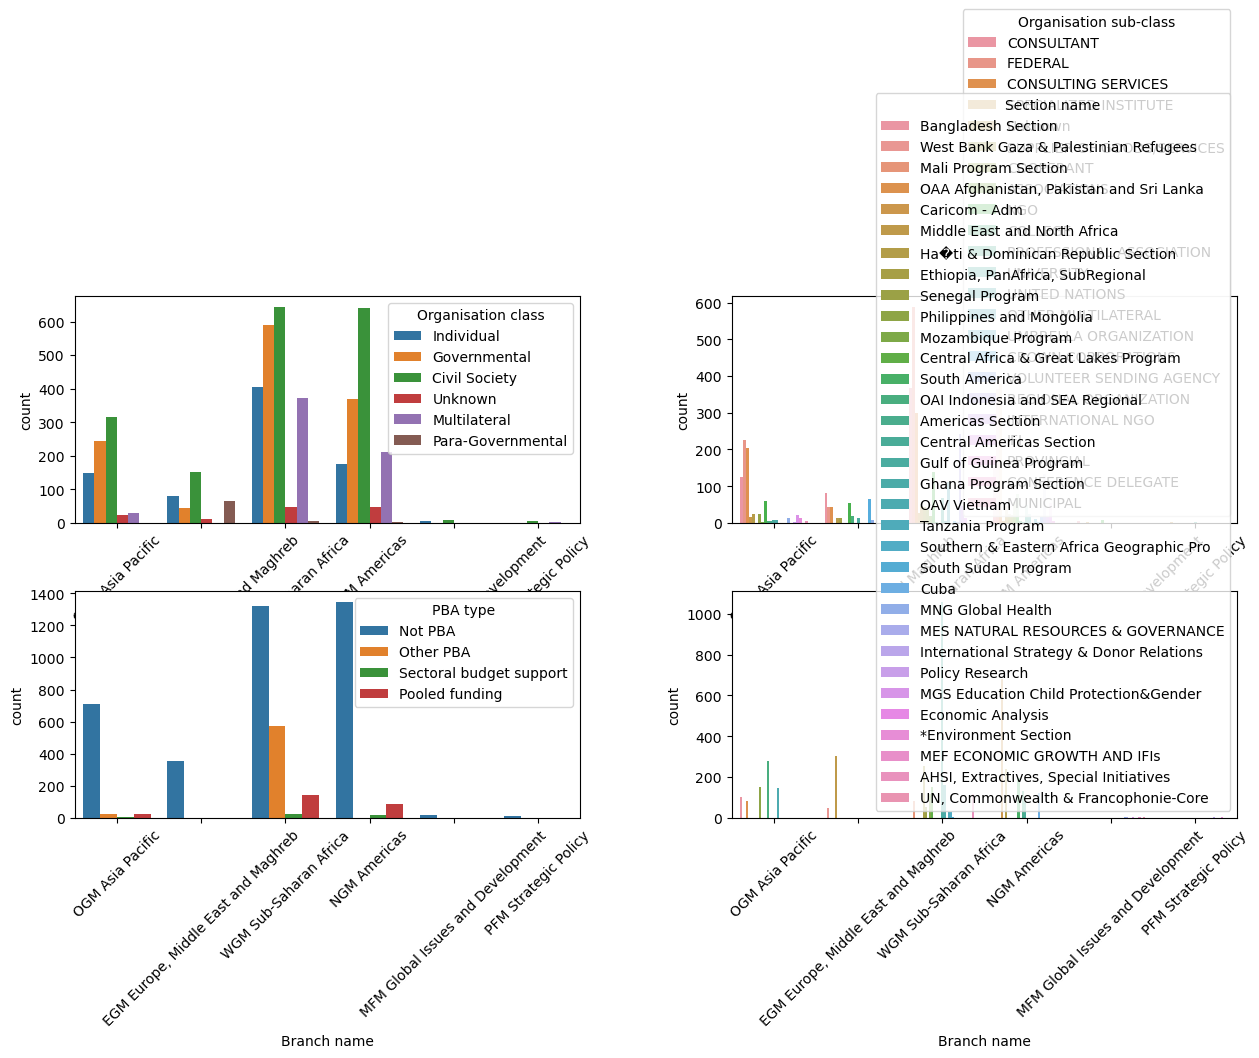

In [20]:
data = list(dfs_new2.values())[45]
cols = [3,4,5,6]
plot_cat(data, 0, cols, (15,8))

In [21]:
coords = {}
for t_name, df in dfs_new2.items():
    x=y=0
    for (idx, col) in enumerate(df):
        if not types.is_numeric_dtype(df[col].dtypes):
            x=x+1
        else:
            y=y+1
    coords[t_name]=[x,y]
x = [val[0] for i, val in enumerate(coords.values())]
y = [val[1] for i, val in enumerate(coords.values())]
label = [val for i, val in enumerate(coords.keys())]

fig = go.Figure(data=go.Scatter(x=label,
                                y=[(i/(1 if j is 0 else j)) for i,j in zip(x, y)],
                                mode='markers',
                                marker_color='blue',
                                text=random.sample(range(1, 51), 50)))

fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title='The distribution of the ratio of Categorical vs Numerical attrs.')
fig.show()

In [22]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=label,
    y=x,
    name='Categorical Fields',
    marker_color='DarkSlateGrey'
))
fig.add_trace(go.Bar(
    x=label,
    y=y,
    name='Numerical Fields',
    marker_color='MediumPurple'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(title='The distribution of the total number of Categorical vs Numerical attrs.')
fig.show()

In [23]:
def get_col_names(df):
    cols = []
    new_sp = []
    for col in df.columns:
        col = re.sub('[^a-zA-Z]', ' ', col).strip()
        sp = col.split(' ')
        for s in sp:
            s = s.strip()
            if s not in new_sp and len(s)>2:
                new_sp.append(s.strip())
                
    cols.append(' '.join(new_sp))    
    return cols

columns = {}
for key, df in dfs_new2.items():
    columns[key] = get_col_names(df)

In [24]:
col_values = []
for _, vals in columns.items():
    col_values.append(' '.join(vals))

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')
model = AutoModel.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

# initialize dictionary that will contain tokenized sentences
tokens = {'input_ids': [], 'attention_mask': []}

for sentence in col_values:
    # tokenize sentence and append to dictionary lists
    new_tokens = tokenizer.encode_plus(sentence, max_length=128, truncation=True,
                                       padding='max_length', return_tensors='pt')
    tokens['input_ids'].append(new_tokens['input_ids'][0])
    tokens['attention_mask'].append(new_tokens['attention_mask'][0])

# reformat list of tensors into single tensor
tokens['input_ids'] = torch.stack(tokens['input_ids'])
tokens['attention_mask'] = torch.stack(tokens['attention_mask'])

In [ ]:
outputs = model(**tokens)
outputs.keys()

In [ ]:
embeddings = outputs.last_hidden_state
print(embeddings.shape)
attention_mask = tokens['attention_mask']
print(attention_mask.shape)
mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
print(mask.shape)
masked_embeddings = embeddings * mask
print(masked_embeddings.shape)
summed = torch.sum(masked_embeddings, 1)
print(summed.shape)
summed_mask = torch.clamp(mask.sum(1), min=1e-9)
print(summed_mask.shape)

In [ ]:
mean_pooled = summed / summed_mask

# convert from PyTorch tensor to numpy array
mean_pooled = mean_pooled.detach().numpy()

def get_similarity(idx):    
    #print(idx)
    # calculate
    sim = cosine_similarity(
        [mean_pooled[idx]],
        mean_pooled[:]
    )
    return sim[0]

In [ ]:
G=nx.Graph()
w_s1 = 0.6
w_s2 = 0.4
beta = 0.5
alpha = 0.05

l_res = list(res)

for k1, v1 in res.items():
    G.add_node(k1)
    sim = get_similarity(l_res.index(k1))
    for k2, v2 in v1.similarities.items():
        #print(f'{k1}__{k2}={v2}\n')
        G.add_node(k2)
        sim_score = sim[l_res.index(k2)]
        if sim_score < beta:
            sim_score = 0
        if v2 >= 0 and v2 <= alpha:
            v2 = (alpha-v2)/alpha
        avg = (w_s1*sim_score + w_s2*v2)
        #print(f'sim[{sim_score}],v2[{v2}],avg[{avg}]')
        if avg >= beta:
            score = w_s1*sim_score + w_s2*v2
            G.add_edge(k1,k2)
            G[k1][k2]['similarity']=score
        
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
nx.draw_networkx(G, ax=ax, edge_color='yellow', node_color='cyan', 
                 with_labels=True, nodelist=G.nodes(), node_size=500)

In [ ]:
A=nx.adjacency_matrix(G) #adjacency matrix
L = csgraph.laplacian(A, normed=True)
w,v = eigsh(L, which='SM')

In [ ]:
def computeclusters(no_clusters, X):
    kmeans = cluster.KMeans(init='k-means++', n_clusters=no_clusters, n_init=20)
    #kmeans = cluster.SpectralClustering(4, affinity='precomputed', n_init=10, assign_labels='discretize')
    #kmeans = cluster.DBSCAN(eps=3, min_samples=2).fit(X)
    kmeans.fit_predict(X)

    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    error = kmeans.inertia_
    #print(labels)

    return X, labels, error

def drawclusters(no_clusters, X, show_label=True): 
    X, labels, _ = computeclusters(no_clusters, X)
    
    get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
    colors = get_colors(no_clusters)

    node_colors = [colors[i] for i in labels]

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    nx.draw_networkx(G, ax=ax, edge_color='yellow', node_color=node_colors, with_labels=True, 
                     nodelist=G.nodes(), node_size=500)
    #nx.draw(G, edge_color='yellow', node_color=node_colors, with_labels=show_label)
    return X, labels, node_colors

In [ ]:
epoch = int(len(G.nodes())/2)
X = v*w

prev_sscore = -np.inf
best_clusters = 2
inertias = []
K = range(1, epoch)
for k in K:
    no_clusters = 2+k
    X, labels, error = computeclusters(no_clusters, X)
    #print(f'error:[{error}], silhouette_score:[{prev_sscore}], best-of-clusters:[{best_clusters}]')
    inertias.append(error)
    sscore = silhouette_score(X, labels)
    if prev_sscore < sscore:
        prev_sscore = sscore
        best_clusters = no_clusters
        
print(f'error:[{error}], silhouette_score:[{prev_sscore}], best-of-clusters:[{best_clusters}]')
X, labels, node_colors = drawclusters(best_clusters, X)

In [ ]:
print(filenames.get('00001'))
print(filenames.get('00019'))

In [ ]:
plt.title(f'Clustering Results ')
plt.scatter(X[:,0], X[:,1], c=node_colors)
#print(X[:,3])
#print(X[:,1])
#sns.scatterplot(X[:,0],X[:,1])
#X

In [ ]:
no_clusters = 14
X, labels, _ = drawclusters(no_clusters, X)
print(f'Silhouette Score(n={no_clusters}): {silhouette_score(X, labels)}')

In [ ]:
print(filenames.get('00005'))
print(filenames.get('00037'))
print(filenames.get('00040'))

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Distortion')
plt.show()

In [ ]:
from community import community_louvain
#comms = community_louvain.best_partition(G)
comms = community_louvain.best_partition(G, weight='weight')

get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
colors = get_colors(len(comms.values()))
    
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size = 75, alpha = 0.8, node_color=colors)
plt.show()

In [ ]:
from communities.algorithms import louvain_method, spectral_clustering, girvan_newman, hierarchical_clustering
from communities.visualization import draw_communities
from communities.visualization import louvain_animation
from communities.utilities import modularity_matrix, modularity

adj_matrix = nx.to_numpy_array(G)

communities, _ = louvain_method(adj_matrix, n=3)
#communities = spectral_clustering(adj_matrix, k=6)
#communities, _ = girvan_newman(adj_matrix, 7) #take long time..
#communities = hierarchical_clustering(adj_matrix, metric="euclidean", linkage="complete", n=14)


draw_communities(adj_matrix, communities)
#louvain_animation(adj_matrix, frames)

mod_matrix = modularity_matrix(adj_matrix)
Q = modularity(mod_matrix, communities)
print(Q)